<h1 align="center" style="background-color:#616161;color:white">Create Time Period Dataset</h1>

<div style="background-color:white; color:#008000; font-family: 'Courier New, Monospace;font-weight: bold">Input Parameters</div>

In [1]:
PeriodGranularity = 30 # E.g. 15, 30, 60. Represents the num of minutes from one time period to the next. Max allowed = 60.

# Root path
root = "C:/DS/Github/MusicRecommendation"  # BA, Windows
#root = "/home/badrul/Documents/github/MusicRecommendation" # BA, Linux

<div style="background-color:white; color:#008000; font-family: 'Courier New, Monospace;font-weight: bold">Import Libraries</div>

In [2]:
# Core
import numpy as np
import pandas as pd
from IPython.core.debugger import Tracer    # Used for debugging
import logging

# File and database management
import csv
import os
import sys
import json
import sqlite3
from pathlib import Path

# Date/Time
import datetime
#import time
from pendulum import Pendulum

# Visualization
#from ggplot import *                        # Preferred vis tool
import matplotlib.pyplot as plt             # Quick viz tool
%matplotlib inline

# Data science (comment out if not needed)
#from sklearn.manifold import TSNE
from sklearn.metrics import roc_curve, auc

# Misc
import random

#-------------- Custom Libs -----------------#
os.chdir(root)

# Import the codebase module
fPath = root + "/1_codemodule"
if fPath not in sys.path: sys.path.append(fPath)

# Custom Libs
import coreCode as cc
import lastfmCode as fm

<div style="background-color:#white; color:#008000; font-family: 'Courier New, Monospace;font-weight: bold">Declare Functions</div>

In [3]:
# Function definition

### Not in use ###
#def toTimeSlot(dt, PeriodGranularity):
#    # If you change this, be sure to changne it further down too
#    return str(int(dt.strftime('%w'))+1) +dt.strftime('-%H-') + str(int((int(dt.strftime('%M'))/PeriodGranularity+1)))


<div style="background-color:#white; color:#008000; font-family: 'Courier New, Monospace;font-weight: bold">Load settings</div>

In [4]:
settingsDict =  cc.loadSettings()
dbPath = root + settingsDict['mainDbPath']
fmSimilarDbPath = root + settingsDict['fmSimilarDbPath']
fmTagsDbPath = root + settingsDict['fmTagsDbPath']
trackMetaDbPath = root + settingsDict['trackmetadata']

<h3 style="background-color:#616161;color:white">1. Convert data into a more usable form</h3>

Here were "fill in the blanks" - for every period where the user did not listen to data a row of data is inserted.

As part of start and end dates for every period, at the granularity level specified above, is setup.


<div style="background-color:#white; color:#008000; font-family: 'Courier New, Monospace;font-weight: bold">Setup tblPeriod</div>

In [5]:
con = sqlite3.connect(dbPath)
cur = con.cursor()

SQLStr = "Select PlayedTimestamp from tblMain"
tblMain = pd.read_sql_query(SQLStr, con)
tblMain.PlayedTimestamp = pd.to_datetime(tblMain.PlayedTimestamp)

startDT = tblMain.PlayedTimestamp.min()
endDT = tblMain.PlayedTimestamp.max()

# This is the main line. Makes a call to code stored in the core module.
dtArray = cc.createDateTimeRange(startDT,endDT, PeriodGranularity)

# Save to db and create the 'HrsFrom6pm' field too
cur.execute('Delete from tblPeriod')
for idx, dt in enumerate(dtArray):
    HrsFrom6pm = abs(int(dt.strftime('%H')) - 18)
    SqlStr="INSERT INTO tblPeriod (PeriodID, PeriodDateTime, HrsFrom6pm) VALUES ({},'{}',{})".format(idx, dt,HrsFrom6pm)
    cur.execute(SqlStr)

con.commit()
con.close()

<div style="background-color:#white; color:#008000; font-family: 'Courier New, Monospace;font-weight: bold">Read in  tblPeriod, tblMain, and tblUser.</div>

In [6]:
con = sqlite3.connect(dbPath)
cur = con.cursor()

### Read tblPeriod, tblMain, and tblUser. These will be re-used later too.

# tblPeriod
SQLStr = "Select * from tblPeriod"
tblPeriod = pd.read_sql_query(SQLStr, con)
tblPeriod.PeriodDateTime = pd.to_datetime(tblPeriod.PeriodDateTime)

# tblUser
SQLStr = "Select UserID as UserID, FirstPlay, LastPlay, TestUser from tblUsers"
tblUser = pd.read_sql_query(SQLStr, con)
tblUser.FirstPlay = pd.to_datetime(tblUser.FirstPlay)
tblUser.LastPlay = pd.to_datetime(tblUser.LastPlay)
# Bring in the PeriodID into tblUsers for the First and Last play
idx = tblPeriod.PeriodDateTime.searchsorted(tblUser['FirstPlay'].values)
tblUser['FirstPlayPeriodID'] = idx
idx = tblPeriod.PeriodDateTime.searchsorted(tblUser['LastPlay'].values)
tblUser['LastPlayPeriodID'] = idx

# tblMain
SQLStr = "Select UserID, PlayedTimestamp from tblMain"
tblMain = pd.read_sql_query(SQLStr, con)
tblMain.PlayedTimestamp = pd.to_datetime(tblMain.PlayedTimestamp)
# Bring in the PeriodID into tblMain
idx = tblPeriod.PeriodDateTime.searchsorted(tblMain['PlayedTimestamp'].values)
tblMain['PeriodID'] = idx

# Drop the timetamp col and just use periodID
tblMain=tblMain.groupby(['UserID','PeriodID']).count().reset_index()

con.close()

<div style="background-color:#white; color:#008000; font-family: 'Courier New, Monospace;font-weight: bold">Create a table that has both the original 'plays' + 'non-plays', utilizing the periods defined previously</div>

In [7]:
con = sqlite3.connect(dbPath)
cur = con.cursor()

SqlStr = "Delete from tblMain2"
cur.execute(SqlStr)
con.commit()

for row in tblUser.itertuples():
    m = tblMain[tblMain.UserID == row.UserID]
    for pid in range (row.FirstPlayPeriodID,row.LastPlayPeriodID):
        # Check if the user listened to music in this period
        playedMusic = m[m.PeriodID == pid]
        playedMusic = (len(playedMusic) > 0) *1
        SqlStr="Insert into tblMain2 (UserID, PeriodID, PlayedMusic) Values ({},{},{})".format(row.UserID, pid,playedMusic)
        cur.execute(SqlStr)    


## Use this if you wish to test for just one user instead
#row = tblUser.iloc[0]
#m = tblMain[tblMain.UserID == row.UserID]
#for pid in range (row.FirstPlayPeriodID,row.LastPlayPeriodID):
    # Check if the user listened to music in this period
#    playedMusic = m[m.PeriodID == pid]
#    playedMusic = (len(playedMusic) > 0) *1
#    SqlStr="Insert into tblMain2 (UserID, PeriodID, PlayedMusic) Values ({},{},{})".format(row.UserID, pid,playedMusic)
#    cur.execute(SqlStr)    

con.commit()
con.close()

<div style="background-color:#white; color:#008000; font-family: 'Courier New, Monospace;font-weight: bold">Manual/offline checks have to be done but here we do a quick plot</div>

In [8]:
# Some quick checks
con = sqlite3.connect(dbPath)
SQLStr = "Select * from tblMain2"
tblMain2 = pd.read_sql_query(SQLStr, con)
con.close()

tblMain2.head(20)

,UserID,PeriodID,PlayedMusic
0,1,23200,1
1,1,23201,1
2,1,23202,1
3,1,23203,1
4,1,23204,1
5,1,23205,1
6,1,23206,1
7,1,23207,1
8,1,23208,1
9,1,23209,0


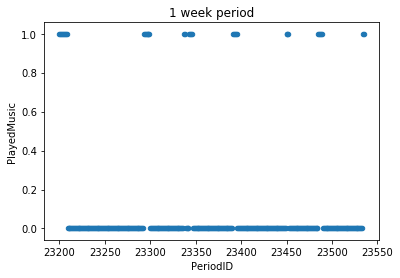

In [9]:
a=tblMain2[0:336].plot.scatter('PeriodID', 'PlayedMusic')
a.set_title('1 week period')

<h3 style="background-color:#616161;color:white">2. Create monthly time-series data</h3>

In [17]:
# Good for report: Select strftime('%H',PlayedTimestamp) as H, count(*) as C from tblMain group by H order by C

con = sqlite3.connect(dbPath)
c = con.cursor()

# Create tblTimeSeriesData
c.execute('DROP TABLE IF EXISTS tblTimeSeriesData')
sqlStr = "CREATE TABLE 'tblTimeSeriesData' ('UserID' INTEGER, HrsFrom6pm Integer, isSun Integer, isMon Integer, isTue Integer, isWed Integer, isThu Integer, isFri Integer, isSat Integer, 't' integer, 't1' Integer, 't2' Integer,'t3' Integer,'t4' Integer,'t5' Integer,'t10' Integer,'t12hrs' Integer,'t24hrs' Integer,'t1wk' Integer,'t2wks' Integer,'t3wks' Integer,'t4wks' Integer)"
c.execute(sqlStr)

# Go through each user
for row in tblUser.itertuples():
    userID = row.UserID
    # Bring back the data for that user
    SQLStr = "Select * from tblMain2 where UserID = {} order by PeriodID".format(userID)
    tblMain2 = pd.read_sql_query(SQLStr, con)
    tblMain2.sort_values('PeriodID')
    tblMain2.set_index('PeriodID',inplace = True)

    minPeriodID = tblMain2.index.min()
    maxPeriodID = tblMain2.index.max()
    periodsInMonth = int(60/PeriodGranularity)*24*7*4
    
    # Go through all the periods for this user and turn into time-series data
    for i in range(minPeriodID+periodsInMonth,maxPeriodID):
        
        periodDt = tblPeriod[tblPeriod.PeriodID == i].PeriodDateTime
        hrsFrom6pm = int(tblPeriod[tblPeriod.PeriodID == i].HrsFrom6pm)
        dayOfWk = int(periodDt.dt.strftime('%w'))
        isSun = (dayOfWk ==0)*1
        isMon = (dayOfWk ==1)*1
        isTue = (dayOfWk ==2)*1
        isWed = (dayOfWk ==3)*1
        isThu = (dayOfWk ==4)*1
        isFri = (dayOfWk ==5)*1
        isSat = (dayOfWk ==6)*1

        t =int(tblMain2.loc[i].PlayedMusic)
        t1 = int(tblMain2.loc[i-1].PlayedMusic)
        t2 = int(tblMain2.loc[i-2].PlayedMusic)
        t3 = int(tblMain2.loc[i-3].PlayedMusic)
        t4 = int(tblMain2.loc[i-4].PlayedMusic)
        t5 = int(tblMain2.loc[i-5].PlayedMusic)
        t10 = int(tblMain2.loc[i-10].PlayedMusic)
        
        t12hrs = int(tblMain2.loc[i-int(60/PeriodGranularity)*12].PlayedMusic)   
        t24hrs = int(tblMain2.loc[i-int(60/PeriodGranularity)*24].PlayedMusic)
        t1wk = int(tblMain2.loc[i-int(60/PeriodGranularity)*168].PlayedMusic)
        t2wks = int(tblMain2.loc[i-int(60/PeriodGranularity)*336].PlayedMusic)
        t3wks = int(tblMain2.loc[i-int(60/PeriodGranularity)*504].PlayedMusic)
        t4wks = int(tblMain2.loc[i-int(60/PeriodGranularity)*672].PlayedMusic)

        SqlStr = "Insert into tblTimeSeriesData (UserID, HrsFrom6pm, isSun,isMon,isTue,isWed,isThu,isFri,isSat,t,t1,t2,t3,t4,t5,t10,t12hrs,t24hrs,t1wk,t2wks,t3wks,t4wks) Values ({},{},{},{},{},{},{},{},{},{},{},{},{},{},{},{},{},{},{},{},{},{})".format(userID,hrsFrom6pm,isSun,isMon,isTue,isWed,isThu,isFri,isSat,t,t1,t2,t3,t4,t5,t10,t12hrs,t24hrs,t1wk,t2wks,t3wks,t4wks)
        c.execute(SqlStr)

con.commit()
con.close()